# CUSTOMIZE YOUR AGENT 

- MIDDLEWARE
- DYNAMIC PROMPT
- HUMAN IN THE LOOP

# MIDDLEWARE 

Middleware lets you insert code specific to your agent at key points in the ReAct loop
- **before_agent**: setup(files, connectors)
- **before_model**: summarization, guardrails
- **wrap_model_call**: dynamic prompt, model
- **wrap_tool_call**: retries, caching
- **after_model**: guardrails
- **after_agent**: teardown

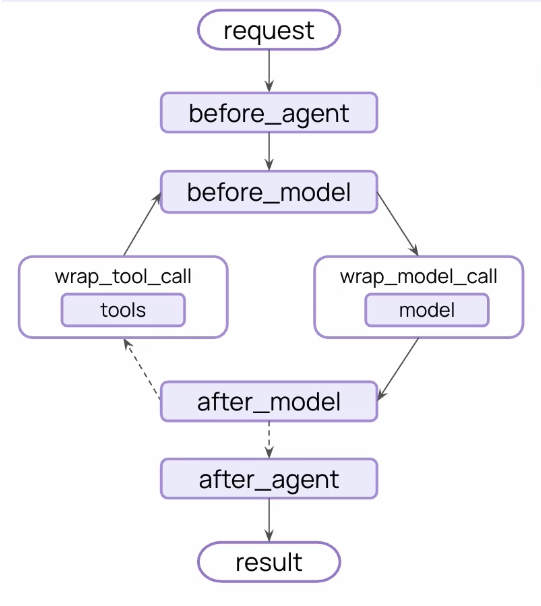



In [1]:
import utility as ut

OPENAI_API_KEY = ut.OPENAI_API_KEY
LANGSMITH_API_KEY = ut.LANGSMITH_API_KEY
MODEL_NAME = ut.MODEL_NAME

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [3]:
from dataclasses import dataclass

@dataclass
class RuntimeContext:
    is_employee: bool
    db: SQLDatabase

In [4]:
from langchain_core.tools import tool
from langgraph.runtime import  get_runtime

@tool
def execute_sql(query:str) -> str:
    """Execute a SQL Lite command and return results"""
    runtime = get_runtime(RuntimeContext)
    db = runtime.context.db

    try:
        return db.run(query)
    except Exception as e:
        return f"Error: {e}"

In [5]:
SYSTEM_PROMPT = """ You are a careful SQLite Analyst

Rules:
 - Think Step-by-Step.
 - When you need data, call the tool `execute_sql` with one SELECT query.
 - Read-Only only; No INSERT/UPDATE/DELETE/ALTER/DROP/TRUNCATE/CREATE/REPLACE.
 - Limit to 5 rows of output unless the user explicitely asks otherwise.
 - If you are getting wrong answer you can always list the tables in the db and check within those tables 
 {table_limits}
 - if the tool returns 'Error:', revise the SQL and try again
 - Prefer explicit column lists; avoid SELECT *
"""

# BUILD A DYNAMIC PROMPT

Utilize runtime context and middleware to generate a dynamic prompt

In [6]:
from langchain.agents.middleware.types import ModelRequest, dynamic_prompt

@dynamic_prompt
def dynamic_system_prompt(request: ModelRequest) -> str:
    if request.runtime.context.is_employee:
        table_limits = "- Allow access to all tables."
    else:
        table_limits = "- Limit access to these tables: Album, Artist, Genre, Playlist, Track, PlaylistTrack."

    return SYSTEM_PROMPT.format(table_limits=table_limits)

Include middleware in create_agent

In [7]:
from langchain.agents import create_agent

agent = create_agent(
    model= MODEL_NAME ,
    tools=[execute_sql],
    middleware = [dynamic_system_prompt],
    context_schema = RuntimeContext,
)

In [8]:
question = "What is the most costly purchase by Frank Harris?"

for step in agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": question
            }
        ]
    },
    context=RuntimeContext(is_employee=False, db=db),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()



/Users/mia/myenv/lib/python3.11/site-packages/pydantic/v1/main.py:1054: UserWarning: LangSmith now uses UUID v7 for run and trace identifiers. This warning appears when passing custom IDs. Please use: from langsmith import uuid7
            id = uuid7()
Future versions will require UUID v7.
  input_data = validator(cls_, input_data)


================================ Human Message =================================

What is the most costly purchase by Frank Harris?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_crJcF59HTZY7BHV8v3uckFcg)
 Call ID: call_crJcF59HTZY7BHV8v3uckFcg
  Args:
    query: SELECT TrackName, UnitPrice FROM Track WHERE TrackId IN (SELECT TrackId FROM PlaylistTrack WHERE PlaylistId IN (SELECT PlaylistId FROM Playlist WHERE Name IN (SELECT Name FROM Artist WHERE Name = 'Frank Harris'))) ORDER BY UnitPrice DESC LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such column: TrackName
[SQL: SELECT TrackName, UnitPrice FROM Track WHERE TrackId IN (SELECT TrackId FROM PlaylistTrack WHERE PlaylistId IN (SELECT PlaylistId FROM Playlist WHERE Name IN (SELECT Name FROM Artist WHERE Name = 'Frank Harris'))) ORDER BY UnitPrice DESC LIMIT 1;]
(Backgrou

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://docs.langchain.com/oss/python/langgraph/errors/GRAPH_RECURSION_LIMIT

In [9]:
question = "What is the most costly purchase by Frank Harris?"

for step in agent.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": question
            }
        ]
    },
    context=RuntimeContext(is_employee=True, db=db),
    stream_mode="values"
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the most costly purchase by Frank Harris?
================================== Ai Message ==================================
Tool Calls:
  execute_sql (call_3vrxSdbgulAiqCl2WUiFqDmI)
 Call ID: call_3vrxSdbgulAiqCl2WUiFqDmI
  Args:
    query: SELECT p.purchase_id, p.amount, p.date FROM purchases p JOIN customers c ON p.customer_id = c.customer_id WHERE c.name = 'Frank Harris' ORDER BY p.amount DESC LIMIT 1;
================================= Tool Message =================================
Name: execute_sql

Error: (sqlite3.OperationalError) no such table: purchases
[SQL: SELECT p.purchase_id, p.amount, p.date FROM purchases p JOIN customers c ON p.customer_id = c.customer_id WHERE c.name = 'Frank Harris' ORDER BY p.amount DESC LIMIT 1;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)
================================== Ai Message ==================================
Tool Calls:
  execute_sql 